Beale synthetic function:

GP CBM versus STP nu = 3 CBM (winner)

https://www.sfu.ca/~ssurjano/beale.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 872 kB 52.8 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=c11d813a047679d93a27bba640321a3f295823c91b4c18f3c567933b2f5e6231
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=69c66b8ef7f9e4c0fb4195289a17fe4ad12dcf3a359df20c86302e986e7dcbd3
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Beale'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Beale':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -4.5 
    ub = +4.5

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2 
                )
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Acquisition function - CBM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=df):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
    

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_1 = GPGO_multi(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    
1  	 [-2.52377989 -0.50196279]	 75.01150716354002	 6.597029498756062	 -119.10000787698007
2  	 [4.5 4.5]	 174813.36328125	 6.597029498756062	 -2.8284275283641667
3  	 [-2.50791183 -0.55066144]	 75.84110174541301	 6.597029498756062	 -31.236298345838495
4  	 [ 4.5 -4.5]	 178131.83203125	 6.597029498756062	 -2.8284275424465677
5  	 [-4.5  4.5]	 169680.83203125	 6.597029498756062	 -2.8283890708029182
6	 [ 1.96144138 -0.01633124]	 0.7673837075120797	 0.7673837075120797	 -2.716929784117204
7  	 [ 0.8547257  -1.25698695]	 7.728590888307354	 0.7

In [13]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    
1  	 [ 0.24449295 -0.61206692]	 11.023806948178922	 8.81624267140378	 -2.8667663083474517
2  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 -2.8284275371386824
3  	 [ 4.5      -2.330512]	 4135.842673241978	 8.81624267140378	 -2.8274929095234635
4  	 [-4.5  4.5]	 169680.83203125	 8.81624267140378	 -2.8263022368710278
5  	 [-1.99029262  0.75765935]	 27.58567606564185	 8.81624267140378	 -10.134994987438358
6  	 [-4.5        -0.29169891]	 146.3844692702774	 8.81624267140378	 -2.077867691864288
7  	 [-4.5 -4.5]	 181853.61328125	 8.81624267140378	 -1

In [14]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_3 = GPGO_multi(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    
1	 [-4.5         1.09809207]	 4.234224860560838	 4.234224860560838	 -3.210772764605211
2  	 [ 4.5 -4.5]	 178131.83203125	 4.234224860560838	 -2.828427542494951
3  	 [-2.9878292  4.5      ]	 74238.41336800413	 4.234224860560838	 -2.8273511494221655
4  	 [-4.5         0.64701487]	 68.1004981884198	 4.234224860560838	 -3.1515627763482708
5  	 [ 0.94975438 -1.21289628]	 7.63864321175239	 4.234224860560838	 -2.659732635895542
6  	 [-0.06177246 -4.5       ]	 73.66246687295929	 4.234224860560838	 -2.1397144446290333
7	 [ 2.46789276 -0.433065

In [15]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_4 = GPGO_multi(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    
1  	 [-4.5  4.5]	 169680.83203125	 3.8409856613776237	 -2.8284215045906596
2  	 [ 4.10053968 -0.2832709 ]	 18.929355874208387	 3.8409856613776237	 -8.9051635553529
3  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 -2.8272398174559252
4  	 [0.88261033 4.5       ]	 7143.198278267247	 3.8409856613776237	 -2.7157883646380347
5  	 [0.31779763 0.44253226]	 11.178712612374834	 3.8409856613776237	 -0.3564603473624618
6  	 [ 4.5        -0.28020639]	 25.649593988060374	 3.8409856613776237	 1.5602034856722307
7  	 [1.09159022 0.46370574]	 

In [16]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_5 = GPGO_multi(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    
1  	 [ 4.5 -4.5]	 178131.83203125	 0.311397019260738	 -2.8284275424335847
2  	 [4.5 4.5]	 174813.36328125	 0.311397019260738	 -2.8284275417731632
3  	 [-4.5        -0.03093234]	 133.9616368591213	 0.311397019260738	 -2.819156841361904
4  	 [ 4.50000000e+00 -7.72555756e-04]	 17.59898401320571	 0.311397019260738	 -2.8144398879959645
5  	 [ 1.58639631 -1.20578363]	 15.85477565435088	 0.311397019260738	 -2.7847417585267116
6  	 [2.21741986 1.04133693]	 16.94977529211399	 0.311397019260738	 -2.6853963944530252
7  	 [-4.5 -4.5]	 181853.61328125

In [17]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_6 = GPGO_multi(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    
1  	 [4.28897718 3.03217734]	 15404.22494396136	 10.038000709758428	 -2.8284275858202035
2  	 [-4.5 -4.5]	 181853.61328125	 10.038000709758428	 -2.8284273007209944
3  	 [-4.5  4.5]	 169680.83203125	 10.038000709758428	 -2.8257229471617755
4  	 [0.25898619 4.5       ]	 732.383187432724	 10.038000709758428	 -2.6149082719339263
5  	 [-1.66601868 -0.91422642]	 59.31499843036169	 10.038000709758428	 -1.4860647925123227
6  	 [0.73141809 0.96128534]	 13.449877595083247	 10.038000709758428	 -1.525052514119509
7	 [ 1.98061852 -0.13328865]

In [18]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_7 = GPGO_multi(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    
1  	 [0.37889366 2.10025002]	 49.35811724591768	 2.9676923934097053	 -3.9638404183898253
2  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 -2.8281998445712437
3  	 [ 4.5 -4.5]	 178131.83203125	 2.9676923934097053	 -2.8282475341951083
4  	 [4.5 4.5]	 174813.36328125	 2.9676923934097053	 -2.8284275424952865
5	 [ 2.65201295e+00 -6.95755509e-04]	 1.4937316147194821	 1.4937316147194821	 -2.480879168592116
6  	 [ 0.6541429 -1.0889335]	 6.910302267760175	 1.4937316147194821	 -2.1959609334821417
7  	 [2.96752336 0.01481325]	 2.

In [19]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_8 = GPGO_multi(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    
1  	 [ 3.34144049 -0.43516188]	 12.054415443632589	 1.8693348557707412	 -6.578453835540984
2  	 [-4.5  4.5]	 169680.83203125	 1.8693348557707412	 -2.828427538813857
3  	 [ 4.5 -4.5]	 178131.83203125	 1.8693348557707412	 -2.827874282325374
4	 [ 2.39289243 -0.17185461]	 1.7543334972318145	 1.7543334972318145	 -2.764853476123619
5  	 [ 2.50880105 -0.1599829 ]	 2.0376544511304107	 1.7543334972318145	 -1.7409721497960864
6  	 [-4.5        -0.36317072]	 150.06796952069564	 1.7543334972318145	 -1.4560445891041773
7  	 [ 2.57449449 -0.1531902

In [20]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 -2.8284275424952865
2  	 [ 4.5 -4.5]	 178131.83203125	 22.479204656276803	 -2.8284275418736082
3  	 [-4.5  4.5]	 169680.83203125	 22.479204656276803	 -2.828427453683953
4	 [4.5        0.17361523]	 12.82115719159232	 12.82115719159232	 -2.8283825724719907
5	 [-0.82241217  1.56405692]	 2.288794395623513	 2.288794395623513	 -2.828346871757036
6	 [1.55082223 0.23431079]	 1.909962335617279	 1.909962335617279	 -2.825950380806098
7  	 [ 2.12729023 -1.42921841]	 66.05047

In [21]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_10 = GPGO_multi(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 -2.8279827106616464
2	 [-0.01600833 -1.48100764]	 14.59992763855108	 14.59992763855108	 -5.327842481603253
3  	 [ 4.5        -0.27594801]	 25.50966936065976	 14.59992763855108	 -2.818833707000896
4  	 [-4.5        -0.20920514]	 142.4802785596254	 14.59992763855108	 -2.1963606877151904
5  	 [-0.41197199  4.5       ]	 1222.7953735913866	 14.59992763855108	 -1.8369598270910439
6  	 [-0.03742058 -1.63163117]	 15.322029300568865	 14.59992763855108	 -1.41198473279582
7	 [ 2.35320446 -0.27

In [22]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_11 = GPGO_multi(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    
1  	 [ 4.5 -4.5]	 178131.83203125	 2.8907294990196846	 -2.828427495666898
2  	 [-4.5  4.5]	 169680.83203125	 2.8907294990196846	 -2.828426726053823
3  	 [ 1.48444217 -0.58493478]	 3.060307871299818	 2.8907294990196846	 -1.0485796082649887
4  	 [ 1.48324703 -0.58513946]	 3.0624010805470183	 2.8907294990196846	 -0.030915451742886114
5  	 [-0.23466562  2.12661652]	 3.9160996815060454	 2.8907294990196846	 0.01153577418675489
6  	 [0.32180584 4.5       ]	 1078.526218296693	 2.8907294990196846	 -2.8253311754820047
7  	 [-0.40581439  1.4566

In [23]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_12 = GPGO_multi(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    
1	 [-2.48337787  1.41316186]	 3.8857764788604188	 3.8857764788604188	 -489.22579403439875
2	 [-2.53263161  1.38547474]	 2.770087783099528	 2.770087783099528	 -286.1053409807391
3  	 [-2.53492315  1.38769905]	 2.8823603142833387	 2.770087783099528	 -202.28008102377066
4  	 [-2.53573224  1.38927566]	 2.9599630011564244	 2.770087783099528	 -156.33603209079968
5  	 [-2.53626746  1.39023986]	 3.00849784826935	 2.770087783099528	 -127.3250920888362
6  	 [-2.53664549  1.39088319]	 3.041362714798481	 2.770087783099528	 -107.34170195226149
7  	 [

In [24]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [0.68616841 0.87186966]	 12.072275435399341	 12.072275435399341	 -4.712002818735367
2  	 [-4.5 -4.5]	 181853.61328125	 12.072275435399341	 -2.828427542494578
3  	 [-4.5  4.5]	 169680.83203125	 12.072275435399341	 -2.8284275401747254
4  	 [-2.31138284 -0.01986263]	 60.044658919948034	 12.072275435399341	 -2.7974539439305466
5  	 [-0.80203185 -2.08636311]	 130.71944601328	 12.072275435399341	 -1.4919234572744933
6  	 [-0.79558399  2.10092831]	 16.26531994583845	 12.072275435399341	 -1.1683265183095164
7  	 [-4.5         0.01058992]	 131

In [25]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_14 = GPGO_multi(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    
1  	 [0.9462644  1.71864453]	 63.57352915255465	 11.367015527968295	 -3.077845831068979
2  	 [-4.5 -4.5]	 181853.61328125	 11.367015527968295	 -2.8284275424168004
3  	 [4.5 4.5]	 174813.36328125	 11.367015527968295	 -2.8284273524186396
4  	 [-4.5         0.43899209]	 96.28965204105123	 11.367015527968295	 -2.8283952637942273
5  	 [ 4.5        -0.08563764]	 19.902036804751372	 11.367015527968295	 -2.8277067014419166
6  	 [-1.55949881  0.08309864]	 40.51724301842816	 11.367015527968295	 -2.7932792095703647
7	 [ 2.17809843 -0.63836247]	 

In [26]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_15 = GPGO_multi(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    
1  	 [-4.5         0.13268602]	 124.3066440459835	 47.082686538130915	 -5.035535885279304
2  	 [4.5 4.5]	 174813.36328125	 47.082686538130915	 -2.8284275424952865
3  	 [-3.10802295  4.48335821]	 78619.74513995284	 47.082686538130915	 -2.8284263522079147
4	 [1.39472311 1.04208166]	 15.933911132157405	 15.933911132157405	 -2.827634491584785
5  	 [-0.29638448 -4.5       ]	 917.5075992832882	 15.933911132157405	 -2.80571249419354
6	 [4.5        0.41818244]	 5.780704613273383	 5.780704613273383	 -2.77142094070103
7  	 [0.62311611 3.354471

In [27]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_16 = GPGO_multi(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 -2.828427542467737
2  	 [-4.5 -4.5]	 181853.61328125	 59.442894178636664	 -2.6344929409429954
3	 [0.53451697 1.22562465]	 18.42172517800162	 18.42172517800162	 -2.3642168093426448
4  	 [ 4.5        -0.44434265]	 32.00109970259423	 18.42172517800162	 -1.574876155589878
5	 [1.93677184 0.55107092]	 2.2349010940340954	 2.2349010940340954	 3.480161104132659
6	 [1.94870073 0.54666876]	 2.1503919930730637	 2.1503919930730637	 1.861241119593656
7	 [1.95298995 0.54509517]	 2.12046128464893

In [28]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_17 = GPGO_multi(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    
1  	 [ 4.5 -4.5]	 178131.83203125	 6.891623366037299	 -2.8284273506607245
2  	 [-4.5  4.5]	 169680.83203125	 6.891623366037299	 -2.8283441479257996
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 -2.7733726864844144
4	 [2.42744102 0.42261095]	 0.22026610941444486	 0.22026610941444486	 -8.319108301005025
5  	 [2.33370459 0.49285553]	 0.6592844643058426	 0.22026610941444486	 -5.6007974875355
6  	 [2.29526902 0.52213004]	 0.9304013938313482	 0.22026610941444486	 -4.383978282828316
7  	 [2.27918993 0.53509911]	 1.0656470930033424	 0.220266109

In [29]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_18 = GPGO_multi(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    
1  	 [ 0.35252655 -0.06916659]	 10.031745982746964	 2.472652645883837	 -5.602049089945273
2  	 [-4.5         2.12030663]	 1473.7753289010866	 2.472652645883837	 -2.828410641703416
3  	 [-1.15387497  0.45527669]	 28.01483629516642	 2.472652645883837	 -0.25528272923055945
4  	 [ 0.69648412 -0.10223175]	 6.688667526059637	 2.472652645883837	 1.0777826124623915
5  	 [ 0.69950075 -0.09689444]	 6.666434295533444	 2.472652645883837	 2.1223455112255287
6  	 [ 0.70107099 -0.09421574]	 6.65485413417329	 2.472652645883837	 2.6924003049136487
7  	 [ 0.7

In [30]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_19 = GPGO_multi(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.544086067314716	 -2.8283958006115206
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 -0.859259603648284
3	 [4.32863904 0.4532675 ]	 3.856872797379538	 3.856872797379538	 -103.78846234931355
4	 [4.327595   0.48570429]	 3.0993558032584048	 3.0993558032584048	 -59.704601181917624
5	 [4.32778103 0.49746441]	 2.837942833879913	 2.837942833879913	 -42.00383635502783
6	 [4.32791476 0.5034278 ]	 2.7079809729201267	 2.7079809729201267	 -32.38674026256657
7  	 [ 1.29220597 -0.74239923]	 4.00021549070553

In [31]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_20 = GPGO_multi(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 -2.828423695047772
2  	 [ 4.5 -4.5]	 178131.83203125	 30.55204392634667	 -1.9075443584061433
3  	 [-4.5  4.5]	 169680.83203125	 30.55204392634667	 -0.26121416490647154
4	 [-4.08134064  0.88543396]	 28.67979686155381	 28.67979686155381	 -31.272983670251048
5	 [-3.65675533  0.95619784]	 18.842718482407328	 18.842718482407328	 -2.6626133892516357
6  	 [ 4.5        -0.43090369]	 31.39045760733378	 18.842718482407328	 -1.0333256507912223
7	 [1.0472289  0.25930798]	 4.692967958400534	 4.692967

In [32]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_1 = GPGO_multi_STP(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    
1  	 [-3.53293661  0.81150384]	 34.869905958738116	 6.597029498756062	 -16283.397365744348
2  	 [ 4.5        -4.29367656]	 135233.99872656938	 6.597029498756062	 -15066.413832372851
3  	 [4.5 4.5]	 174813.36328125	 6.597029498756062	 -69070.11528500271
4  	 [-4.5  4.5]	 169680.83203125	 6.597029498756062	 -105031.6466269581
5	 [2.36692073 0.05978621]	 0.6048517475487423	 0.6048517475487423	 -125245.59925023679
6  	 [ 0.54769129 -2.33128876]	 45.638240411492305	 0.6048517475487423	 -119406.28614349462
7  	 [0.14415155 4.5       ]	 273.147

In [33]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    
1  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 -1398.982492340302
2  	 [ 4.5        -2.33644298]	 4193.598448632004	 8.81624267140378	 -93450.64823680806
3  	 [-4.5  4.5]	 169680.83203125	 8.81624267140378	 -87440.21695202493
4  	 [-4.5 -4.5]	 181853.61328125	 8.81624267140378	 -114865.92598501027
5  	 [0.07449882 2.78542402]	 27.558220094133276	 8.81624267140378	 -135972.10503764218
6	 [2.99976298 0.55868358]	 0.08783362560033484	 0.08783362560033484	 -129616.94666703726
7  	 [ 2.39519406 -4.5       ]	 50012.78190930751	 0.08783362560033484

In [34]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_3 = GPGO_multi_STP(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    
1  	 [ 2.52283288 -1.74272821]	 259.55509339560894	 41.912714742005974	 -16132.166706960232
2  	 [-4.5         2.44842854]	 3906.4866767218664	 41.912714742005974	 -14936.19297514876
3  	 [ 4.5 -4.5]	 178131.83203125	 41.912714742005974	 -14106.815248606095
4  	 [-1.17481522  4.5       ]	 11083.203632399458	 41.912714742005974	 -85016.98793669301
5  	 [-0.15376504 -4.5       ]	 287.9308186825642	 41.912714742005974	 -80803.80456281651
6	 [ 4.5        -0.01651156]	 18.024014647303144	 18.024014647303144	 -77020.22315905271
7  	 [-0.187

In [35]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_4 = GPGO_multi_STP(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    
1  	 [-4.5  4.5]	 169680.83203125	 3.8409856613776237	 -86645.3225953127
2  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 -121082.99340322023
3  	 [0.88997841 4.37964623]	 6212.227499146847	 3.8409856613776237	 -145244.96253192204
4  	 [0.77930271 0.53221484]	 8.00428225408437	 3.8409856613776237	 -136965.00422619734
5  	 [-0.2459832 -4.5      ]	 653.7072045995599	 3.8409856613776237	 -129917.03739507555
6  	 [4.5 4.5]	 174813.36328125	 3.8409856613776237	 -123849.15238354063
7  	 [-4.5         0.39643327]	 101.13934364782195	 

In [36]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_5 = GPGO_multi_STP(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    
1  	 [ 4.5 -4.5]	 178131.83203125	 0.311397019260738	 -11370.729175295073
2  	 [4.5 4.5]	 174813.36328125	 0.311397019260738	 -95795.66054578181
3  	 [-4.5 -4.5]	 181853.61328125	 0.311397019260738	 -125170.21657511666
4  	 [-4.5         0.16586694]	 121.98020769770423	 0.311397019260738	 -145862.35285419467
5  	 [ 0.95813986 -2.19001132]	 107.59317174630142	 0.311397019260738	 -138342.39768770972
6  	 [0.55685976 4.5       ]	 2969.210797320905	 0.311397019260738	 -131859.8331915877
7  	 [ 4.5        -0.57987068]	 39.58435429174969	 0.311

In [37]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_6 = GPGO_multi_STP(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    
1  	 [4.25528696 1.11328007]	 32.59986923309303	 10.038000709758428	 -25292.398021020017
2  	 [-4.5 -4.5]	 181853.61328125	 10.038000709758428	 -23414.434393671654
3  	 [1.19497955 4.5       ]	 12841.083052024373	 10.038000709758428	 -93527.48392552469
4  	 [-4.5  4.5]	 169680.83203125	 10.038000709758428	 -88386.07128664615
5  	 [4.5 4.5]	 174813.36328125	 10.038000709758428	 -113061.66311811059
6  	 [-0.68727419 -3.25132528]	 763.7233751823815	 10.038000709758428	 -131011.49387963668
7  	 [1.67278644 1.31035736]	 38.21512250145

In [38]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_7 = GPGO_multi_STP(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    
1  	 [1.84967754 4.18905978]	 19833.952753238307	 2.9676923934097053	 -1917.6146365090299
2  	 [ 4.5 -4.5]	 178131.83203125	 2.9676923934097053	 -10749.35864760616
3  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 -89631.70460383143
4  	 [-3.5381093  -1.17462676]	 226.89781537510947	 2.9676923934097053	 -120375.4358545831
5  	 [ 1.1935121  -0.74132089]	 4.160201921693568	 2.9676923934097053	 -114196.8336695444
6  	 [4.5 4.5]	 174813.36328125	 2.9676923934097053	 -108590.7772251809
7  	 [-1.71539377  4.5       ]	 24063.5

In [39]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_8 = GPGO_multi_STP(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    
1  	 [ 3.81659363 -3.60434002]	 34929.0787604046	 1.8693348557707412	 -46755.82070516076
2  	 [-4.5  4.5]	 169680.83203125	 1.8693348557707412	 -47142.21853355647
3  	 [-4.5        -0.36304781]	 150.06125945482415	 1.8693348557707412	 -95614.97451792611
4  	 [-0.5461566   2.57308492]	 38.697144796753825	 1.8693348557707412	 -90135.3013768198
5  	 [-2.4100002   0.92926494]	 19.057896433277797	 1.8693348557707412	 -85435.99849221106
6  	 [ 0.66681943 -2.8466911 ]	 230.16501299730947	 1.8693348557707412	 -81346.81049879183
7  	 [-0.24339

In [40]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 -2189.491819384943
2  	 [ 4.49443445 -3.63069242]	 50698.449666897395	 22.479204656276803	 -28584.086096851737
3  	 [-3.24764682  4.5       ]	 87869.61201357104	 22.479204656276803	 -36844.29072424835
4	 [ 1.45819671 -0.02499372]	 1.9898012872111077	 1.9898012872111077	 -54057.95318040876
5	 [4.5        0.56578974]	 1.9848269795455777	 1.9848269795455777	 -51277.03635616505
6  	 [-1.315572    0.62744381]	 26.321366768825058	 1.9848269795455777	 -48890.37536722534

In [41]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_10 = GPGO_multi_STP(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 -27848.407159802748
2  	 [ 4.43120194 -0.28283803]	 24.481660852121887	 15.229523981513257	 -96933.42714521589
3  	 [-4.5        -0.28471098]	 146.04334393906427	 15.229523981513257	 -90672.8225452358
4  	 [-4.5  4.5]	 169680.83203125	 15.229523981513257	 -85473.18790704261
5  	 [-1.01939979  0.14468066]	 29.43502665955063	 15.229523981513257	 -111059.74226578434
6  	 [-0.24166564  4.5       ]	 373.1163033647741	 15.229523981513257	 -105873.65942600298
7	 [ 1.75250846 -0.41837352]	 

In [42]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_11 = GPGO_multi_STP(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    
1  	 [ 4.5 -4.5]	 178131.83203125	 2.8907294990196846	 -35661.10996508993
2  	 [-4.5  4.5]	 169680.83203125	 2.8907294990196846	 -100777.11299452253
3  	 [ 2.29211706 -0.50279573]	 4.071863451586047	 2.8907294990196846	 -126817.46596564006
4  	 [0.50382561 4.5       ]	 2460.5199555798663	 2.8907294990196846	 -119546.32077956869
5  	 [ 0.64835298 -2.71706049]	 163.25930050772362	 2.8907294990196846	 -113403.31979971114
6  	 [ 4.5       -0.1815252]	 22.602955168417214	 2.8907294990196846	 -108032.18076520381
7	 [-2.57491267  1.31232602

In [43]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_12 = GPGO_multi_STP(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    
1  	 [-0.72304674  2.5309349 ]	 73.03172045583321	 48.45196617039589	 -54104.58927121479
2  	 [4.5 4.5]	 174813.36328125	 48.45196617039589	 -50065.64987244586
3  	 [-4.5 -4.5]	 181853.61328125	 48.45196617039589	 -99162.37249829444
4	 [1.747522   0.21426788]	 1.1560883434043148	 1.1560883434043148	 -126843.87367625163
5  	 [-0.36719477 -2.28587085]	 62.248591660512055	 1.1560883434043148	 -120330.0674212082
6  	 [-4.5       -0.2157456]	 142.78313420745982	 1.1560883434043148	 -114696.47654344125
7  	 [4.5        0.06093588]	 15.92931811

In [44]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [-1.3158115   1.32655875]	 3.4642422629217675	 3.4642422629217675	 -28167.594329540265
2  	 [-4.5 -4.5]	 181853.61328125	 3.4642422629217675	 -26073.081594155192
3  	 [-4.5  4.5]	 169680.83203125	 3.4642422629217675	 -94140.92624680404
4  	 [-0.80518983 -1.70374224]	 68.97768919476525	 3.4642422629217675	 -119476.26943579133
5  	 [-4.5         0.00618149]	 131.9927621514794	 3.4642422629217675	 -113343.31104428372
6  	 [ 0.15747762 -4.5       ]	 169.4922384792166	 3.4642422629217675	 -108066.23883069541
7  	 [ 4.5 -4.5]	 178131.832031

In [45]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_14 = GPGO_multi_STP(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    
1  	 [3.01327541 1.66548484]	 253.09845407672958	 11.367015527968295	 -51753.604618512865
2  	 [-2.62696579 -4.32451325]	 49594.152069326265	 11.367015527968295	 -47913.98332297744
3  	 [-4.5         0.32401315]	 108.64486390004147	 11.367015527968295	 -51221.63471038237
4  	 [4.5 4.5]	 174813.36328125	 11.367015527968295	 -48291.45748593817
5  	 [ 4.5        -0.50778338]	 35.19112514866296	 11.367015527968295	 -90596.4088911106
6  	 [-1.7550428   0.33672932]	 40.185498634031156	 11.367015527968295	 -86375.97593148926
7	 [ 2.07764949 

In [46]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_15 = GPGO_multi_STP(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    
1	 [-4.5         0.95252428]	 20.521730488671086	 20.521730488671086	 -4055.1018990554276
2  	 [4.5 4.5]	 174813.36328125	 20.521730488671086	 -3750.058884981403
3  	 [-1.69667446  4.5       ]	 23530.945439997893	 20.521730488671086	 -87477.03974603838
4	 [1.19931749 0.81215117]	 9.29409537296638	 9.29409537296638	 -83215.29411471036
5  	 [-0.43553668 -4.5       ]	 1880.2627991082713	 9.29409537296638	 -78942.92987544235
6  	 [4.5        0.19262683]	 12.285501983022465	 9.29409537296638	 -75256.97596218118
7  	 [-4.5 -4.5]	 181853.61

In [47]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_16 = GPGO_multi_STP(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 -33791.95660016394
2  	 [-4.5 -4.5]	 181853.61328125	 59.442894178636664	 -98539.71383435103
3	 [0.80046417 1.12228674]	 17.33186801703919	 17.33186801703919	 -129475.21974010528
4  	 [ 4.5        -0.44212872]	 31.899087191045805	 17.33186801703919	 -122069.81797175333
5  	 [ 4.5 -4.5]	 178131.83203125	 17.33186801703919	 -115798.2725372603
6  	 [0.15909833 4.5       ]	 320.22314029599295	 17.33186801703919	 -134003.13497665696
7  	 [-4.5        -0.67631353]	 176.33557490541028	 1

In [48]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_17 = GPGO_multi_STP(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    
1  	 [ 4.5 -4.5]	 178131.83203125	 6.891623366037299	 -17348.897557739117
2  	 [-4.5  4.5]	 169680.83203125	 6.891623366037299	 -96560.71704359853
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 -123920.7454108043
4  	 [-0.02486322  3.61919004]	 8.022639333344316	 6.891623366037299	 -142967.14156705776
5  	 [ 0.75673152 -2.16818758]	 60.47769874974685	 6.891623366037299	 -135619.43129259773
6  	 [4.32110218 0.0892068 ]	 12.946872244122787	 6.891623366037299	 -129178.06562221936
7  	 [ 0.54364178 -4.5       ]	 2416.155728145549	 6.89162336

In [49]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_18 = GPGO_multi_STP(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    
1  	 [-4.32979265  1.96404161]	 777.7615327665158	 2.472652645883837	 -20942.433598363452
2  	 [-1.45475112  0.23619931]	 36.43677705462541	 2.472652645883837	 -19390.68093038853
3  	 [-4.5  4.5]	 169680.83203125	 2.472652645883837	 -18121.926311644253
4  	 [-4.5        -0.73295058]	 184.38338420042558	 2.472652645883837	 -81796.54677546336
5  	 [ 4.5        -0.01493859]	 17.98152427031193	 2.472652645883837	 -77584.65818777897
6  	 [-1.21617823  2.60063254]	 330.8509898665987	 2.472652645883837	 -73970.22384821164
7  	 [ 0.33361237 -2.06921

In [50]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_19 = GPGO_multi_STP(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.544086067314716	 -5467.489019554153
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 -95347.6151339971
3	 [ 1.42909539 -0.74234365]	 3.940801610854979	 3.940801610854979	 -124877.68044035317
4  	 [-1.12587483  4.5       ]	 10153.441778092938	 3.940801610854979	 -117729.56179918216
5  	 [-1.41135926  1.17024932]	 7.72340687047576	 3.940801610854979	 -111700.29993139523
6  	 [-4.5  4.5]	 169680.83203125	 3.940801610854979	 -106444.66985034468
7  	 [-4.5 -4.5]	 181853.61328125	 3.940801610854979	 

In [51]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_20 = GPGO_multi_STP(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 -4295.0424066182295
2  	 [ 4.5 -4.5]	 178131.83203125	 30.55204392634667	 -97285.1794270907
3  	 [-4.5  4.5]	 169680.83203125	 30.55204392634667	 -127325.8356370602
4	 [ 4.5        -0.35980893]	 28.46237354896076	 28.46237354896076	 -144250.3706372279
5	 [1.64513014 0.10629244]	 1.353602957666027	 1.353602957666027	 -136843.16066555976
6  	 [-3.6662911  -0.64214123]	 128.69627952961852	 1.353602957666027	 -130432.26668802924
7  	 [-0.46856616 -4.5       ]	 2159.3302862488827	 1.353602957

In [52]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-0.2647683321581744, -0.5027718963537986)

In [53]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(1.2262582437704117, -2.432310872156322)

In [54]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(0.6632751203126286, -0.22551439653993802)

In [55]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(1.345729016312703, 1.345729016312703)

In [56]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(-1.1666865916873388, -1.1666865916873388)

In [57]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(0.05488113488586477, 0.7016688478744593)

In [58]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(-0.04873540168263814, 1.087784678899565)

In [59]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(0.5620890111284649, 0.6255826754918475)

In [60]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(0.647083522292, 0.6855317463832675)

In [61]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(0.844715441680145, 0.7757413554317721)

In [62]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(1.061508892077436, 0.020248248860193614)

In [63]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(1.0188790103467582, 0.1450421889602318)

In [64]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(1.3370895723211031, 1.1235889620021593)

In [65]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(0.5140197003518563, 1.0828833490766334)

In [66]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(-4.071084892877722, 1.0801942870074464)

In [67]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(0.7241324152048956, 0.25977139691848306)

In [68]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(-1.51291887534478, 1.9303066691801607)

In [69]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(0.9052915200747084, -0.13448514838992134)

In [70]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(0.9055301808725589, 1.3713841571474965)

In [71]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(0.8631248712248454, -2.6124409547442453)

In [72]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [73]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [74]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [75]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [76]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [77]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [78]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [79]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [80]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [81]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [82]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [83]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [84]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [85]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [86]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [87]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [88]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [89]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [90]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [91]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [92]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [93]:
### Summarise arrays: 'GP'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]


In [94]:
### Summarise arrays: 'STP'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]


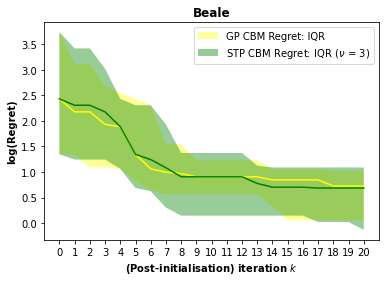

In [95]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'yellow')
plt.plot(median_stp, color = 'green')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'yellow', alpha=0.4, label='GP CBM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'green', alpha=0.4, label='STP CBM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!
